In [1]:
# pip install simpy

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import simpy
import random

## Load Dataset & Small Cleaning

In [2]:
data = pd.read_excel('input_busy_day.xlsx')
data.head()

,number,type,Airline,Company,ATIME,DTIME,SATIME,SDTIME,STA,STD,...,cleaning,ambulift,prm,inboundPax,inboundBag,outboundPax,outboundBag,standChange,priority,day
0,1,A320,Wizz Air,1,07:05:00,07:50:00,425,470,60,105,...,False,False,0,108,92,119,101,0,1,1
1,2,A320,Wizz Air,1,07:05:00,07:35:00,425,455,60,90,...,False,False,0,89,69,86,66,0,1,1
2,3,A321,Wizz Air,1,07:05:00,07:40:00,425,460,60,95,...,False,False,0,124,114,101,94,0,1,1
3,4,A320,Vueling,3,07:10:00,07:55:00,430,475,65,110,...,False,False,0,98,90,86,80,0,1,1
4,5,A320,Wizz Air,1,07:25:00,08:15:00,445,495,80,130,...,False,False,0,116,93,100,80,0,1,1


In [3]:
def convert_to_minutes(time_obj):
    return time_obj.hour * 60 + time_obj.minute - 360 # -360 as we are opening the airport at suppose 6 in the morning (6*60)

# Apply the function to the 'time' column
data['arrival_time'] = data['ATIME'].apply(convert_to_minutes)
data.head()

,number,type,Airline,Company,ATIME,DTIME,SATIME,SDTIME,STA,STD,...,ambulift,prm,inboundPax,inboundBag,outboundPax,outboundBag,standChange,priority,day,arrival_time
0,1,A320,Wizz Air,1,07:05:00,07:50:00,425,470,60,105,...,False,0,108,92,119,101,0,1,1,65
1,2,A320,Wizz Air,1,07:05:00,07:35:00,425,455,60,90,...,False,0,89,69,86,66,0,1,1,65
2,3,A321,Wizz Air,1,07:05:00,07:40:00,425,460,60,95,...,False,0,124,114,101,94,0,1,1,65
3,4,A320,Vueling,3,07:10:00,07:55:00,430,475,65,110,...,False,0,98,90,86,80,0,1,1,70
4,5,A320,Wizz Air,1,07:25:00,08:15:00,445,495,80,130,...,False,0,116,93,100,80,0,1,1,85


In [4]:
data['interarrival_time'] = data['arrival_time'].diff()

# Fill the first NaN value with 0 or any appropriate value
data['interarrival_time'].fillna(0, inplace=True)

# make the first entry to be equal the first arrival time

data.loc[0, 'interarrival_time'] = data.loc[0, 'arrival_time']

data.head()

,number,type,Airline,Company,ATIME,DTIME,SATIME,SDTIME,STA,STD,...,prm,inboundPax,inboundBag,outboundPax,outboundBag,standChange,priority,day,arrival_time,interarrival_time
0,1,A320,Wizz Air,1,07:05:00,07:50:00,425,470,60,105,...,0,108,92,119,101,0,1,1,65,65.0
1,2,A320,Wizz Air,1,07:05:00,07:35:00,425,455,60,90,...,0,89,69,86,66,0,1,1,65,0.0
2,3,A321,Wizz Air,1,07:05:00,07:40:00,425,460,60,95,...,0,124,114,101,94,0,1,1,65,0.0
3,4,A320,Vueling,3,07:10:00,07:55:00,430,475,65,110,...,0,98,90,86,80,0,1,1,70,5.0
4,5,A320,Wizz Air,1,07:25:00,08:15:00,445,495,80,130,...,0,116,93,100,80,0,1,1,85,15.0


In [5]:
data['departure_time'] = data['SDTIME'] - (60 * 6)
data.head()

,number,type,Airline,Company,ATIME,DTIME,SATIME,SDTIME,STA,STD,...,inboundPax,inboundBag,outboundPax,outboundBag,standChange,priority,day,arrival_time,interarrival_time,departure_time
0,1,A320,Wizz Air,1,07:05:00,07:50:00,425,470,60,105,...,108,92,119,101,0,1,1,65,65.0,110
1,2,A320,Wizz Air,1,07:05:00,07:35:00,425,455,60,90,...,89,69,86,66,0,1,1,65,0.0,95
2,3,A321,Wizz Air,1,07:05:00,07:40:00,425,460,60,95,...,124,114,101,94,0,1,1,65,0.0,100
3,4,A320,Vueling,3,07:10:00,07:55:00,430,475,65,110,...,98,90,86,80,0,1,1,70,5.0,115
4,5,A320,Wizz Air,1,07:25:00,08:15:00,445,495,80,130,...,116,93,100,80,0,1,1,85,15.0,135


In [6]:
data.tail()

,number,type,Airline,Company,ATIME,DTIME,SATIME,SDTIME,STA,STD,...,inboundPax,inboundBag,outboundPax,outboundBag,standChange,priority,day,arrival_time,interarrival_time,departure_time
69,70,320,Wizz Air,1,21:15:00,21:45:00,1275,1305,910,940,...,99,81,111,91,0,1,1,915,5.0,945
70,71,320,Wizz Air,1,21:20:00,21:55:00,1280,1315,915,950,...,108,89,120,98,0,1,1,920,5.0,955
71,72,320,Wizz Air,1,21:25:00,21:55:00,1285,1315,920,950,...,81,84,96,100,0,1,1,925,5.0,955
72,73,738,El Al,2,22:15:00,23:30:00,1335,1410,970,1045,...,130,98,118,88,0,1,1,975,50.0,1050
73,74,733,Tarom,3,22:35:00,23:20:00,1355,1400,990,1035,...,98,94,114,109,0,1,1,995,20.0,1040


<Axes: ylabel='Frequency'>

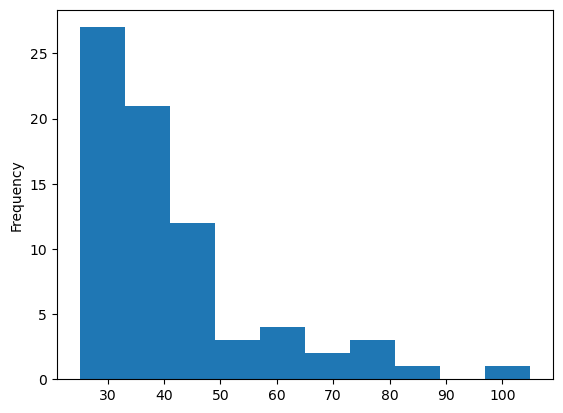

In [7]:
data['turnaround_window'] = data['STD'] - data['STA']

# create beautiful histogram for data['turnaround_window']  

data['turnaround_window'].plot(kind='hist')

### Edit Preferred Stand attribut

Since initially we have like almost 30 preferred stand id denoting there would be unique 30 stand, we consider to lower this value, and assign new preferred stand attribute randomly.

In [8]:
random.seed(100)
data['preferredStand'] = data['preferredStand'].apply(lambda x: random.randint(0, 14))

In [17]:
data.preferredStand.head(10)

0     2
1     7
2     7
3    12
4     2
5    11
6     6
7    11
8     5
9     6
Name: preferredStand, dtype: int64

### Archieved Previous Development Code

Please ignore these hidden codes



First Code

In [13]:
# import simpy
# import random
# import numpy as np

# flight_delay = []

# class Aircraft:
#     def __init__(self, env, stand, name, id):
#         self.env = env
#         self.stand = stand
#         self.name = name
#         self.id = id

#     def turnaround(self):
#         yield self.env.timeout(20)

#     def action(self):
#         with self.stand.request() as req:
#             yield req
#             print(f"{self.env.now} - {self.name}: Arrived at stand")
#             yield self.env.process(self.turnaround())
#             flight_delay.append(self.env.now - data['departure_time'][self.id])
#             print(f"{self.env.now} - {self.name}: Departed from stand")

# def aircraft_generator(env, stand):
#     i = 0
#     while True:
#         t = data['interarrival_time'][i]
        
#         yield env.timeout(t)
#         # print(t,"has come")
        
#         aircraft = Aircraft(env, stand, name=f"Aircraft {i}", id = i)
#         env.process(aircraft.action())
#         i += 1

# def monitor_utilization(env, stand, utilization_log, interval=1):
#     while True:
#         utilization = len(stand.users) / stand.capacity
#         utilization_log.append((env.now, utilization))
#         yield env.timeout(interval)

# # Set up the environment and resources
# env = simpy.Environment()
# stand = simpy.Resource(env, capacity=2)

# # List to store utilization logs
# utilization_log = []

# # Start processes
# env.process(aircraft_generator(env, stand))
# env.process(monitor_utilization(env, stand, utilization_log))

# # Run the simulation
# env.run(until=800)

# mean_utilization = np.mean([utilization for _, utilization in utilization_log])
# print(f"Mean Utilization: {mean_utilization:.2f}")


Add Ground Handler

In [22]:
# import simpy
# import random
# import numpy as np



# class Aircraft:
#     def __init__(self, env, stand, ground_handler, name, id):
#         self.env = env
#         self.stand = stand
#         self.ground_handler = ground_handler
#         self.name = name
#         self.id = id

#     def turnaround(self):
#         with self.ground_handler.request() as req:
#             yield req
#             yield self.env.timeout(20)

#     def action(self):
#         with self.stand.request() as req:
#             yield req
#             print(f"{self.env.now} - {self.name}: Arrived at stand")
#             yield self.env.process(self.turnaround())
#             flight_delay.append(self.env.now - data['departure_time'][self.id])
#             print(f"{self.env.now} - {self.name}: Departed from stand")

# def aircraft_generator(env, stand, ground_handler):
#     i = 0
#     while True:
#         t = data['interarrival_time'][i]
        
#         yield env.timeout(t)
#         # print(t,"has come")
        
#         aircraft = Aircraft(env, stand, ground_handler, name=f"Aircraft {i}", id = i)
#         env.process(aircraft.action())
#         i += 1

# def monitor_utilization(env, stand, utilization_log, interval=1):
#     while True:
#         utilization = len(stand.users) / stand.capacity
#         utilization_log.append((env.now, utilization))
#         yield env.timeout(interval)

# # Set up the environment and resources
# env = simpy.Environment()
# stand = simpy.Resource(env, capacity=3)
# ground_handler = simpy.Resource(env, capacity =2)

# # List to store utilization logs
# utilization_log = []

# flight_delay = []

# # Start processes
# env.process(aircraft_generator(env, stand, ground_handler))
# env.process(monitor_utilization(env, stand, utilization_log))

# # Run the simulation
# env.run(until=800)

# mean_utilization = np.mean([utilization for _, utilization in utilization_log])
# print(f"Mean Utilization: {mean_utilization:.2f}")


Initial preferred stand from GPT

In [ ]:
# import simpy
# import random
# import numpy as np

# class Stand:
#     def __init__(self, stand_id):
#         self.stand_id = stand_id

# class Aircraft:
#     def __init__(self, env, stands, ground_handler, name, id, stand_id):
#         self.env = env
#         self.stands = stands
#         self.ground_handler = ground_handler
#         self.name = name
#         self.stand_id = stand_id
#         self.id = id

#     def turnaround(self):
#         with self.ground_handler.request() as req:
#             yield req
#             yield self.env.timeout(random.normalvariate(35, 5))

#     def action(self):
#         try:
#             # Request a specific stand
#             req = self.stands.get(lambda stand: stand.stand_id == self.stand_id)
#             stand = yield req
#         except simpy.Interrupt:
#             # If the specific stand is not available, take any available stand
#             req = self.stands.get()
#             stand = yield req
#         print(f"{self.env.now} - {self.name}: Arrived at stand {stand.stand_id}")
#         yield self.env.process(self.turnaround())
#         print(f"{self.env.now} - {self.name}: Departed from stand {stand.stand_id}")
#         yield self.stands.put(stand)
#         flight_delay.append(self.env.now - data['departure_time'][self.id])

# def aircraft_generator(env, stands):
#     i = 0
#     while i <=73:
#         t = data['interarrival_time'][i]
#         yield env.timeout(t)
#         stand_id = i % stands.capacity  # For simplicity, cyclically request stand IDs
#         aircraft = Aircraft(env, stands, ground_handler, name=f"Aircraft {i}", id = i, stand_id=stand_id)
#         env.process(aircraft.action())
#         i += 1


# def monitor_utilization(env, stands, utilization_log, interval=1):
#     while True:
#         utilization = stands.capacity - len(stands.items)
#         utilization_log.append((env.now, utilization / stands.capacity))
#         yield env.timeout(interval)

# # Set up the environment and resources
# env = simpy.Environment()
# stands = simpy.FilterStore(env, capacity=23)
# ground_handler = simpy.Resource(env, capacity =3)

# # Initialize stands with specific IDs
# for i in range(5):
#     stands.put(Stand(stand_id=i))

# # List to store utilization logs
# utilization_log = []
# flight_delay = []

# # Start processes
# env.process(aircraft_generator(env, stands))
# env.process(monitor_utilization(env, stands, utilization_log))

# # Run the simulation
# env.run(until=1000)

# mean_utilization = np.mean([utilization for _, utilization in utilization_log])
# print(f"Mean Utilization: {mean_utilization:.2f}")


Log codes for aircraft action

In [23]:
    # def action(self):
        
        
    #     def is_stand_available(stands, stand_id):
    #         return any(stand.stand_id == stand_id for stand in stands.items)
        
    #     if is_stand_available(stands, self.stand_id): 
    #         # Request a specific stand
    #         req = self.stands.get(lambda stand: stand.stand_id == self.stand_id)
    #         print(self.id, 'success')
    #         stand = yield req
    #     else:
    #         # If the specific stand is not available, take any available stand
    #         print(self.id, 'unsucceeded')
    #         req = self.stands.get()
    #         stand = yield req
                
                
            
    #     print(f"{self.env.now} - {self.name}: Arrived at stand {stand.stand_id}")
    #     yield self.env.process(self.turnaround(stand.distance))
    #     print(f"{self.env.now} - {self.name}: Departed from stand {stand.stand_id}")
    #     yield self.stands.put(stand)
    #     flight_delay.append(self.env.now - data['departure_time'][self.id])      
            
            
            

        # with self.stands.get(lambda stand: stand.stand_id == self.stand_id) as req_preffered_stand:
        #     stand = yield req_preffered_stand | env.timeout(0)
            
        #     if req_preffered_stand in stand:
        #         print(self.id, 'success to go to preferred stand')
        #         stand = yield req_preffered_stand
                                
        #     else: 
        #         # yield self.stands.get()
        #         stand = yield self.stands.get()
        #         print(self.id, 'unsucceeded going to preferred stand and move to other stand')
                
                
            
        #     print(f"{self.env.now} - {self.name}: Arrived at stand {stand.stand_id}")
        #     yield self.env.process(self.turnaround(stand.distance))
        #     print(f"{self.env.now} - {self.name}: Departed from stand {stand.stand_id}")
        #     yield self.stands.put(stand)
        #     flight_delay.append(self.env.now - data['departure_time'][self.id])  
          
        
        # try:
        #     # Request a specific stand
        #     req = self.stands.get(lambda stand: stand.stand_id == self.stand_id)
        #     print(self.id, 'success')
        #     stand = yield req
        # except simpy.Interrupt:
        #     # If the specific stand is not available, take any available stand
        #     print(self.id, 'unsucceeded')
        #     req = self.stands.get()
        #     stand = yield req
        # print(f"{self.env.now} - {self.name}: Arrived at stand {stand.stand_id}")
        # yield self.env.process(self.turnaround(stand.distance))
        # print(f"{self.env.now} - {self.name}: Departed from stand {stand.stand_id}")
        # yield self.stands.put(stand)
        # flight_delay.append(self.env.now - data['departure_time'][self.id])

### Main Code

In [28]:
import simpy
import random
import numpy as np


class Stand:
    def __init__(self, stand_id, distance):
        self.stand_id = stand_id
        self.distance = distance

class Aircraft:
    def __init__(self, env, stands, ground_handler, name, id, stand_id):
        self.env = env
        self.stands = stands
        self.ground_handler = ground_handler
        self.name = name
        self.stand_id = stand_id
        self.id = id

    def turnaround(self, distance):
        with self.ground_handler.request() as req:
            yield req
            # Time to travel to the stand
            yield self.env.timeout(distance)
            # Time for the turnaround
            yield self.env.timeout(random.normalvariate(20, 3))
            # Time to travel back to the workcentre
            yield self.env.timeout(distance)

    def action(self):
        
        
        def is_stand_available(stands, stand_id):
            return any(stand.stand_id == stand_id for stand in stands.items)
        
        if is_stand_available(stands, self.stand_id): 
            # Request a specific stand
            req = self.stands.get(lambda stand: stand.stand_id == self.stand_id)
            # print(self.id, 'success') #verfication
            stand = yield req
        else:
            # If the specific stand is not available, take any available stand
            # print(self.id, 'unsucceeded') #verfication
            req = self.stands.get()
            stand = yield req
            
        print(f"{self.env.now} - {self.name}: Arrived at stand {stand.stand_id}")
        yield self.env.process(self.turnaround(stand.distance))
        print(f"{self.env.now} - {self.name}: Departed from stand {stand.stand_id}")
        yield self.stands.put(stand)
        flight_delay.append(self.env.now - data['departure_time'][self.id])      


def aircraft_generator(env, stands):
    i = 0
    while i <= 73:
        t = data['interarrival_time'][i]
        yield env.timeout(t)
        stand_id = data['preferredStand'][i]  # For simplicity, cyclically request stand IDs
        # stand_id = i % stands.capacity  # For simplicity, cyclically request stand IDs
        aircraft = Aircraft(env, stands, ground_handler, name=f"Aircraft {i}", id=i, stand_id=stand_id)
        env.process(aircraft.action())
        # print(i) # verification for aircraft creation
        i += 1

def monitor_utilization(env, stands, utilization_log, interval=1):
    while True:
        utilization = stands.capacity - len(stands.items)
        utilization_log.append((env.now, utilization / stands.capacity))
        yield env.timeout(interval)

# Set up the environment and resources
env = simpy.Environment()
stands = simpy.FilterStore(env, capacity=15)
ground_handler = simpy.Resource(env, capacity=4)

# Initialize stands with specific IDs and distances
distances = [2, 3, 2, 3, 2, 5, 2, 3, 2, 3, 2, 5, 8, 4, 2]
for i in range(15):
    stands.put(Stand(stand_id=i, distance=distances[i]))

# List to store utilization logs
utilization_log = []
flight_delay = []


# Start processes
env.process(aircraft_generator(env, stands))
env.process(monitor_utilization(env, stands, utilization_log))

# Run the simulation
env.run(until= 60 * 18 ) #from 6 in the morning until midnight

mean_utilization = np.mean([utilization for _, utilization in utilization_log])




65.0 - Aircraft 0: Arrived at stand 2
65.0 - Aircraft 1: Arrived at stand 7
65.0 - Aircraft 2: Arrived at stand 0
70.0 - Aircraft 3: Arrived at stand 12
85.0 - Aircraft 4: Arrived at stand 1
85.0 - Aircraft 5: Arrived at stand 11
85.75755519295478 - Aircraft 0: Departed from stand 2
90.0 - Aircraft 6: Arrived at stand 6
94.19990042711937 - Aircraft 2: Departed from stand 0
94.3360214779163 - Aircraft 1: Departed from stand 7
95.0 - Aircraft 7: Arrived at stand 3
95.0 - Aircraft 8: Arrived at stand 5
102.27975795520393 - Aircraft 3: Departed from stand 12
105.0 - Aircraft 9: Arrived at stand 4
110.0 - Aircraft 10: Arrived at stand 8
113.93118487103386 - Aircraft 4: Departed from stand 1
115.0 - Aircraft 11: Arrived at stand 12
115.0 - Aircraft 12: Arrived at stand 1
115.0 - Aircraft 13: Arrived at stand 9
118.60700982284473 - Aircraft 6: Departed from stand 6
120.0 - Aircraft 14: Arrived at stand 10
123.24363827662609 - Aircraft 5: Departed from stand 11
126.22485008643781 - Aircraft 7:

In [ ]:
print(f'Serviced Aircraft: {len(flight_delay)}')
print(f"Mean Utilization: {mean_utilization:.2f}")

In [29]:
# convert flight_delay list to dataframe

flight_delay_df = pd.DataFrame(flight_delay)

number_delayed_flights = len(flight_delay_df[flight_delay_df[0] > 0])
number_non_delayed_flights = len(flight_delay_df[flight_delay_df[0] <= 0])


# filter flight_delay_df with positive values

print('Number of delayed flights:', number_delayed_flights)
print('Number of non-delayed flights:', number_non_delayed_flights )
print('Delayed Flights Ratio:', round(number_delayed_flights / (number_delayed_flights + number_non_delayed_flights) * 100, 2), '%')

print('Average delayed flights (minutes):', round(flight_delay_df[flight_delay_df[0] > 0].mean().values[0], 2) )

Number of delayed flights: 20
Number of non-delayed flights: 54
Delayed Flights Ratio: 27.03 %
Average delayed flights (minutes): 14.72
